In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import iris
import iris.coords as coords
import iris.plot as iplt

from six.moves import zip
import os.path

Global average annual temperature maps
======================================

Produces maps of global temperature forecasts from the A1B and E1 scenarios.

The data used comes from the HadGEM2-AO model simulations for the A1B and E1 scenarios, both of which were derived using the IMAGE
Integrated Assessment Model (Johns et al. 2010; Lowe et al. 2009).

References
----------

* Johns T.C., et al. (2010) Climate change under aggressive mitigation: The ENSEMBLES multi-model experiment. Climate
    Dynamics (submitted)

* Lowe J.A., C.D. Hewitt, D.P. Van Vuuren, T.C. Johns, E. Stehfest, J-F. Royer, and P. van der Linden, 2009. New
    Study For Climate Modeling, Analyses, and Scenarios. Eos Trans. AGU, Vol 90, No. 21.



###  http://scitools.org.uk/iris/docs/v1.9.0/html/gallery.html

In [2]:

def cop_metadata_callback(cube, field, filename):
    """ A function which adds an "Experiment" coordinate which comes from the filename. """

    # Extract the experiment name (such as a1b or e1) from the filename (in this case it is just the parent folder's name)
    containing_folder = os.path.dirname(filename)
    experiment_label = os.path.basename(containing_folder)

    # Create a coordinate with the experiment label in it
    exp_coord = coords.AuxCoord(experiment_label, long_name='Experiment', units='no_unit')

    # and add it to the cube
    cube.add_aux_coord(exp_coord)


def main():
    # Load e1 and a1 using the callback to update the metadata
    #dpath = iris.sample_data_path('E1.2098.pp')
    dpath = 'sample_data/E1.2098.pp'
    e1 = iris.load_cube(  dpath,
                        callback=cop_metadata_callback)

    #dpath = iris.sample_data_path('A1B.2098.pp')
    dpath = 'sample_data/A1B.2098.pp'
    a1b = iris.load_cube(  dpath,
                         callback=cop_metadata_callback)

    # Load the global average data and add an 'Experiment' coord it
    #dpath = iris.sample_data_path('pre-industrial.pp')
    dpath = 'sample_data/pre-industrial.pp'
    global_avg = iris.load_cube( dpath )

    # Define evenly spaced contour levels: -2.5, -1.5, ... 15.5, 16.5 with the specific colours
    levels = np.arange(20) - 2.5
    red = np.array([0, 0, 221, 239, 229, 217, 239, 234, 228, 222, 205, 196, 161, 137, 116, 89, 77, 60, 51]) / 256.
    green = np.array([16, 217, 242, 243, 235, 225, 190, 160, 128, 87, 72, 59, 33, 21, 29, 30, 30, 29, 26]) / 256.
    blue = np.array([255, 255, 243, 169, 99, 51, 63, 37, 39, 21, 27, 23, 22, 26, 29, 28, 27, 25, 22]) / 256.

    # Put those colours into an array which can be passed to conourf as the specific colours for each level
    colors = np.array([red, green, blue]).T

    # Subtract the global


    # Iterate over each latitude longitude slice for both e1 and a1b scenarios simultaneously
    for e1_slice, a1b_slice in zip(e1.slices(['latitude', 'longitude']),
                                   a1b.slices(['latitude', 'longitude'])):

        time_coord = a1b_slice.coord('time')

        # Calculate the difference from the mean
        delta_e1 = e1_slice - global_avg
        delta_a1b = a1b_slice - global_avg

        # Make a wider than normal figure to house two maps side-by-side
        fig = plt.figure(figsize=(12, 5))

        # Get the time datetime from the coordinate
        time = time_coord.units.num2date(time_coord.points[0])
        # Set a title for the entire figure, giving the time in a nice format of "MonthName Year". Also, set the y value for the
        # title so that it is not tight to the top of the plot.
        fig.suptitle('Annual Temperature Predictions for ' + time.strftime("%Y"), y=0.9, fontsize=18)

        # Add the first subplot showing the E1 scenario
        plt.subplot(121)
        plt.title('HadGEM2 E1 Scenario',  fontsize=10)
        iplt.contourf(delta_e1, levels, colors=colors, linewidth=0, extend='both')
        plt.gca().coastlines()
        # get the current axes' subplot for use later on
        plt1_ax = plt.gca()

        # Add the second subplot showing the A1B scenario
        plt.subplot(122)
        plt.title('HadGEM2 A1B-Image Scenario',  fontsize=10)
        contour_result = iplt.contourf(delta_a1b, levels, colors=colors, linewidth=0, extend='both')
        plt.gca().coastlines()
        # get the current axes' subplot for use later on
        plt2_ax = plt.gca()


        # Now add a colourbar who's leftmost point is the same as the leftmost point of the left hand plot
        # and rightmost point is the rightmost point of the right hand plot

        # Get the positions of the 2nd plot and the left position of the 1st plot
        left, bottom, width, height = plt2_ax.get_position().bounds
        first_plot_left = plt1_ax.get_position().bounds[0]

        # the width of the colorbar should now be simple
        width = left - first_plot_left + width

        # Add axes to the figure, to place the colour bar
        colorbar_axes = fig.add_axes([first_plot_left, bottom + 0.07, width, 0.03])

        # Add the colour bar
        cbar = plt.colorbar(contour_result, colorbar_axes, orientation='horizontal')

        # Label the colour bar and add ticks
        cbar.set_label(e1_slice.units)
        cbar.ax.tick_params(length=0)

        iplt.show()


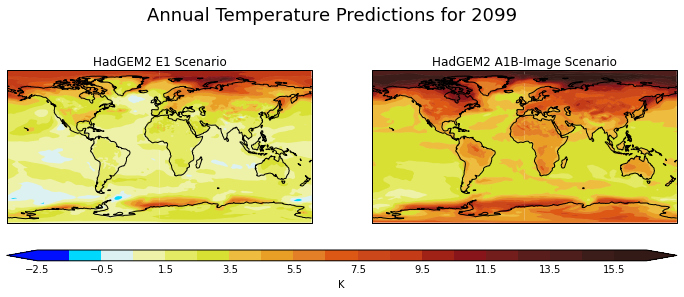

In [3]:
main()